In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set up nice plotting defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Load your dataset
df = pd.read_csv('tennis_breakthrough_dataset.csv')

# First look at the data
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

ModuleNotFoundError: No module named 'pandas'

In [ ]:
# ============================================================================
# PHASE 1: UNDERSTANDING THE DATA
# ============================================================================

print("="*80)
print("EXPLORATORY DATA ANALYSIS - TENNIS BREAKTHROUGH PREDICTION")
print("="*80)

# 1. Basic Dataset Info
print("\n📋 DATASET OVERVIEW")
print("-" * 80)
print(f"Total players: {len(df)}")
print(f"Total features: {len(df.columns) - 2}")  # Excluding player_id and breakthrough
print(f"Columns: {df.columns.tolist()}")

# 2. Check for Missing Values
print("\n🔍 MISSING VALUE CHECK")
print("-" * 80)
missing = df.isnull().sum()
print(missing)
if missing.sum() == 0:
    print("✅ No missing values - data is complete!")

# 3. Target Variable Analysis
print("\n🎯 TARGET VARIABLE: Breakthrough Status")
print("-" * 80)
breakthrough_counts = df['breakthrough'].value_counts()
breakthrough_pct = df['breakthrough'].value_counts(normalize=True) * 100

print(f"No Breakthrough (0): {breakthrough_counts[0]} players ({breakthrough_pct[0]:.1f}%)")
print(f"Breakthrough (1): {breakthrough_counts[1]} players ({breakthrough_pct[1]:.1f}%)")
print(f"\n⚠️  Class Imbalance Ratio: {breakthrough_counts[0]/breakthrough_counts[1]:.1f}:1")
print("   → This means we'll need special techniques (SMOTE, class weights) during modeling")

# 4. Feature Statistics
print("\n📊 FEATURE STATISTICS")
print("-" * 80)

features = ['win25_count', 'win25_rate', 'win50_count', 'win50_rate', 
            'win100_count', 'win100_rate', 'win_rate_4month']

# Create comprehensive statistics table
stats_df = pd.DataFrame({
    'Feature': features,
    'Min': [df[f].min() for f in features],
    'Max': [df[f].max() for f in features],
    'Mean': [df[f].mean() for f in features],
    'Median': [df[f].median() for f in features],
    'Std Dev': [df[f].std() for f in features],
    'Variance': [df[f].var() for f in features]
})

print(stats_df.round(3).to_string(index=False))

# 5. Breakthrough vs Non-Breakthrough Comparison
print("\n⚖️  BREAKTHROUGH vs NON-BREAKTHROUGH COMPARISON")
print("-" * 80)

breakthrough_players = df[df['breakthrough'] == 1]
non_breakthrough_players = df[df['breakthrough'] == 0]

comparison_df = pd.DataFrame({
    'Feature': features,
    'Breakthrough_Mean': [breakthrough_players[f].mean() for f in features],
    'NonBreakthrough_Mean': [non_breakthrough_players[f].mean() for f in features],
    'Difference': [breakthrough_players[f].mean() - non_breakthrough_players[f].mean() for f in features],
    'Pct_Increase': [(breakthrough_players[f].mean() / non_breakthrough_players[f].mean() - 1) * 100 for f in features]
})

print(comparison_df.round(3).to_string(index=False))

print("\n💡 Interpretation:")
print("   - Positive 'Difference' means breakthrough players score HIGHER on average")
print("   - 'Pct_Increase' shows how much better breakthrough players perform (%)")
print("   - Features with large differences are likely more predictive")

EXPLORATORY DATA ANALYSIS - TENNIS BREAKTHROUGH PREDICTION

📋 DATASET OVERVIEW
--------------------------------------------------------------------------------
Total players: 293
Total features: 7
Columns: ['player_id', 'win25_count', 'win25_rate', 'win50_count', 'win50_rate', 'win100_count', 'win100_rate', 'win_rate_4month', 'breakthrough']

🔍 MISSING VALUE CHECK
--------------------------------------------------------------------------------
player_id          0
win25_count        0
win25_rate         0
win50_count        0
win50_rate         0
win100_count       0
win100_rate        0
win_rate_4month    0
breakthrough       0
dtype: int64
✅ No missing values - data is complete!

🎯 TARGET VARIABLE: Breakthrough Status
--------------------------------------------------------------------------------
No Breakthrough (0): 284 players (96.9%)
Breakthrough (1): 9 players (3.1%)

⚠️  Class Imbalance Ratio: 31.6:1
   → This means we'll need special techniques (SMOTE, class weights) during mo

In [ ]:
#### Deep dive into the win100 paradox
print("="*80)
print("🔍 INVESTIGATING THE WIN100 ANOMALY")
print("="*80)

# Look at the relationship between win100 and win25
print("\n📊 Correlation Analysis:")
print(f"Correlation between win25_count and win100_count: {df['win25_count'].corr(df['win100_count']):.3f}")
print(f"Correlation between win25_count and win50_count: {df['win25_count'].corr(df['win50_count']):.3f}")

# Compare opportunity patterns
print("\n🎾 Opportunity Analysis:")
print(f"Breakthrough players - Avg attempts vs 100+ higher: {breakthrough_players['win100_count'].sum() / breakthrough_players['win100_rate'].replace(0, np.nan).count():.1f}")
print(f"Non-breakthrough players - Avg attempts vs 100+ higher: {non_breakthrough_players['win100_count'].sum() / non_breakthrough_players['win100_rate'].replace(0, np.nan).count():.1f}")

# Look at specific breakthrough players
print("\n🏆 BREAKTHROUGH PLAYERS - Detailed View:")
print(breakthrough_players[['player_id', 'win25_count', 'win50_count', 'win100_count', 
                            'win25_rate', 'win50_rate', 'win100_rate', 'win_rate_4month']].to_string(index=False))

# Look at high win100 players who DIDN'T break through
print("\n❌ HIGH WIN100 PLAYERS WHO DIDN'T BREAKTHROUGH:")
high_win100_no_breakthrough = non_breakthrough_players.nlargest(10, 'win100_count')
print(high_win100_no_breakthrough[['player_id', 'win100_count', 'win100_rate', 
                                    'win25_count', 'win_rate_4month']].to_string(index=False))

📊 CREATING FEATURE DISTRIBUTION PLOTS


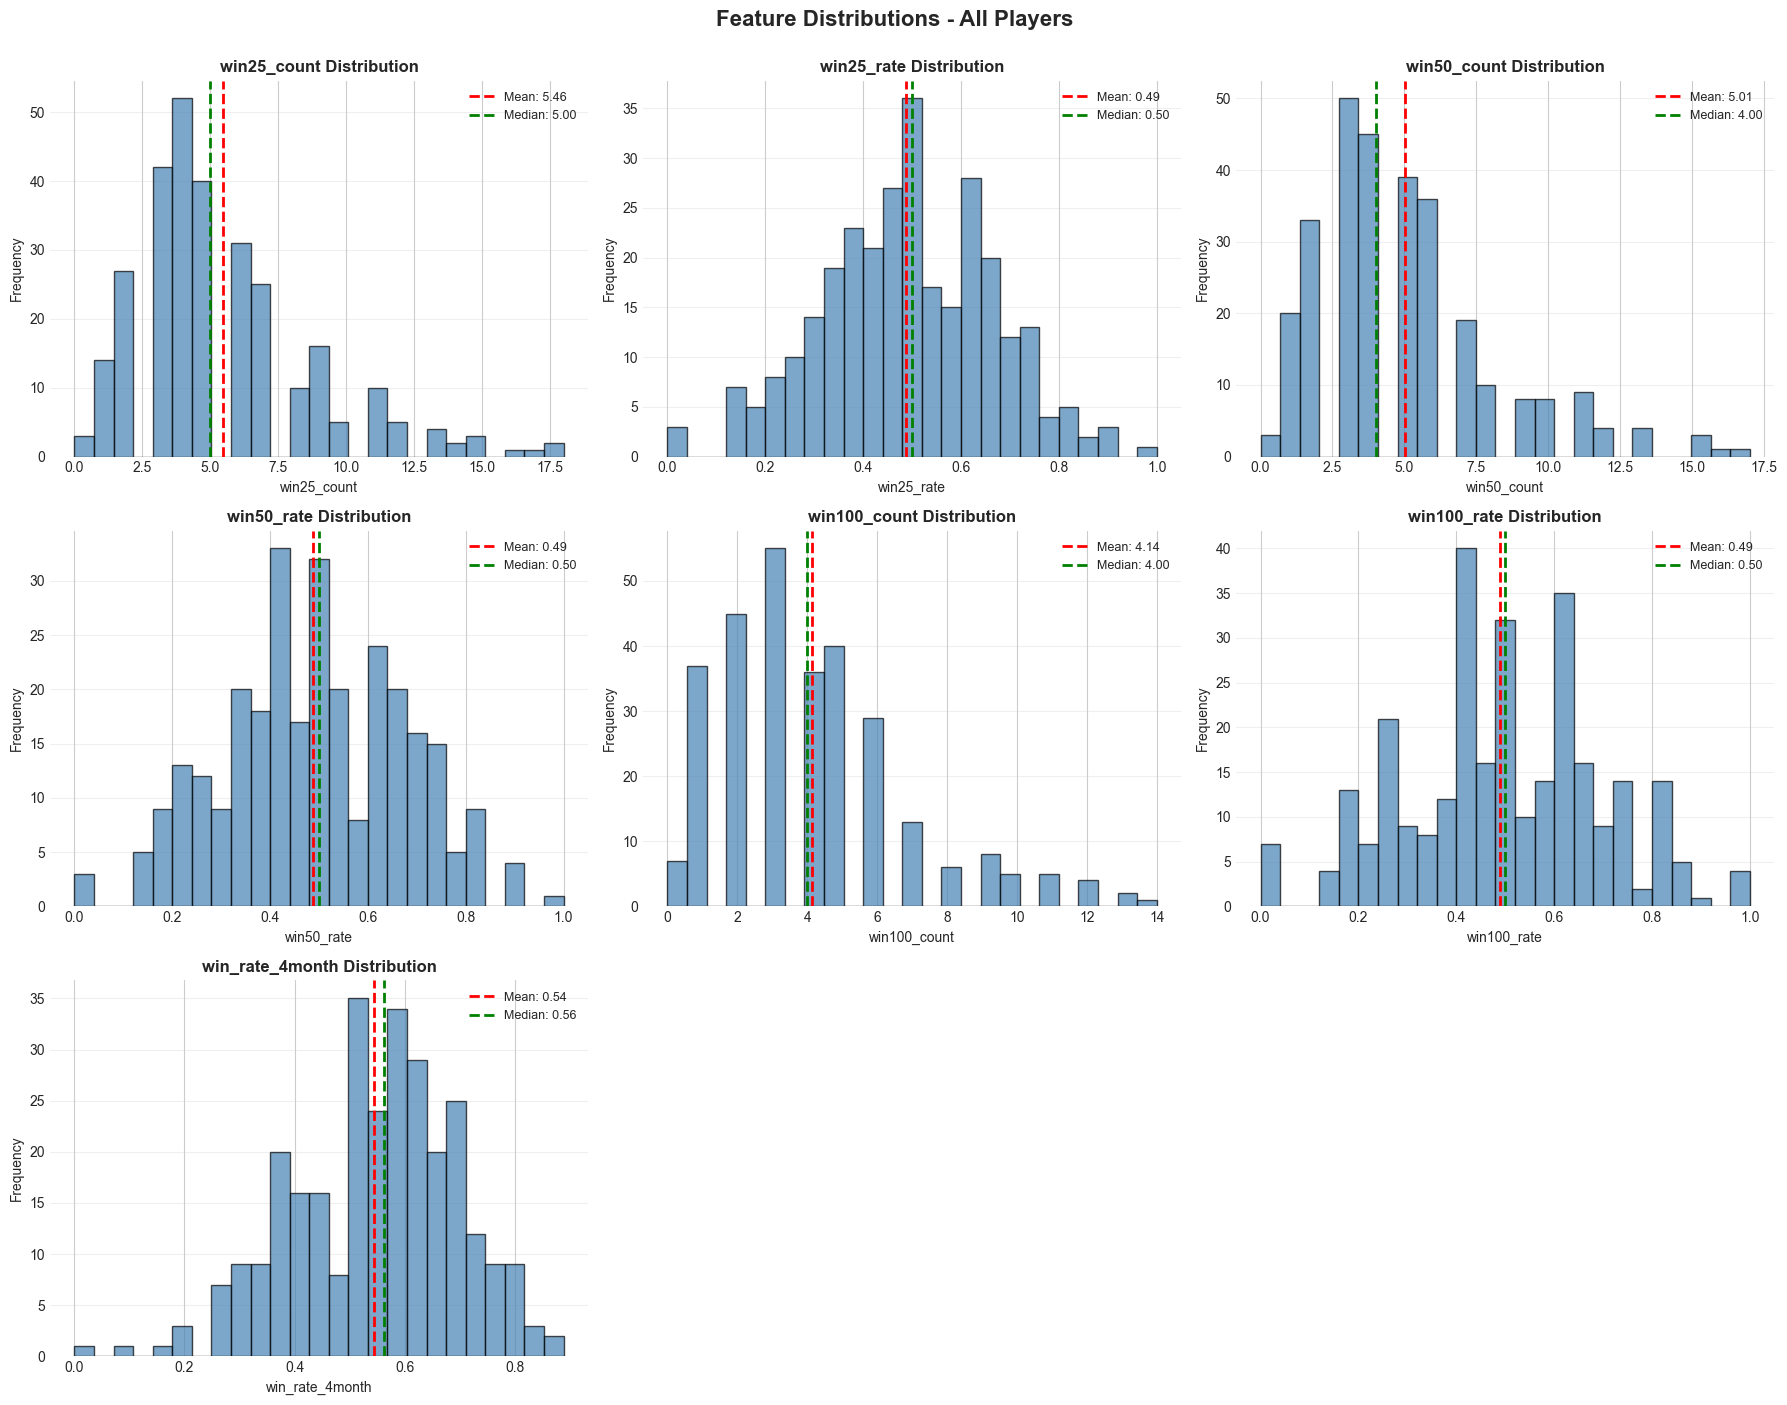

✅ Histograms created! Look for:
   • Skewness (are distributions symmetric?)
   • Outliers (unusual values far from the mean)
   • Zeros (many players with 0 wins?)


In [ ]:
# ============================================================================
# PHASE 2: VISUALIZATIONS
# ============================================================================

import matplotlib.pyplot as plt
import seaborn as sns

# Set style for clean, professional plots
sns.set_style('whitegrid')
sns.set_palette('husl')

# 1. FEATURE DISTRIBUTIONS - Histograms
print("="*80)
print("📊 CREATING FEATURE DISTRIBUTION PLOTS")
print("="*80)

features = ['win25_count', 'win25_rate', 'win50_count', 'win50_rate', 
            'win100_count', 'win100_rate', 'win_rate_4month']

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    axes[i].hist(df[feature], bins=25, color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'{feature} Distribution', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')
    
    # Add vertical lines for mean and median
    axes[i].axvline(df[feature].mean(), color='red', linestyle='--', 
                    linewidth=2, label=f'Mean: {df[feature].mean():.2f}')
    axes[i].axvline(df[feature].median(), color='green', linestyle='--', 
                    linewidth=2, label=f'Median: {df[feature].median():.2f}')
    axes[i].legend(fontsize=9)
    axes[i].grid(axis='y', alpha=0.3)

# Remove extra subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Feature Distributions - All Players', fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("✅ Histograms created! Look for:")
print("   • Skewness (are distributions symmetric?)")
print("   • Outliers (unusual values far from the mean)")
print("   • Zeros (many players with 0 wins?)")


📊 BREAKTHROUGH vs NON-BREAKTHROUGH COMPARISON PLOTS


/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_92975/3681474991.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data_to_plot,
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_92975/3681474991.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data_to_plot,
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_92975/3681474991.py:19: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[i].boxplot(data_to_plot,
/var/folders/9p/sptj_sd15hngqxcftwzx121r0000gn/T/ipykernel_92975/3681474991.py:19: MatplotlibDeprecationWarning: The 'labels' paramet

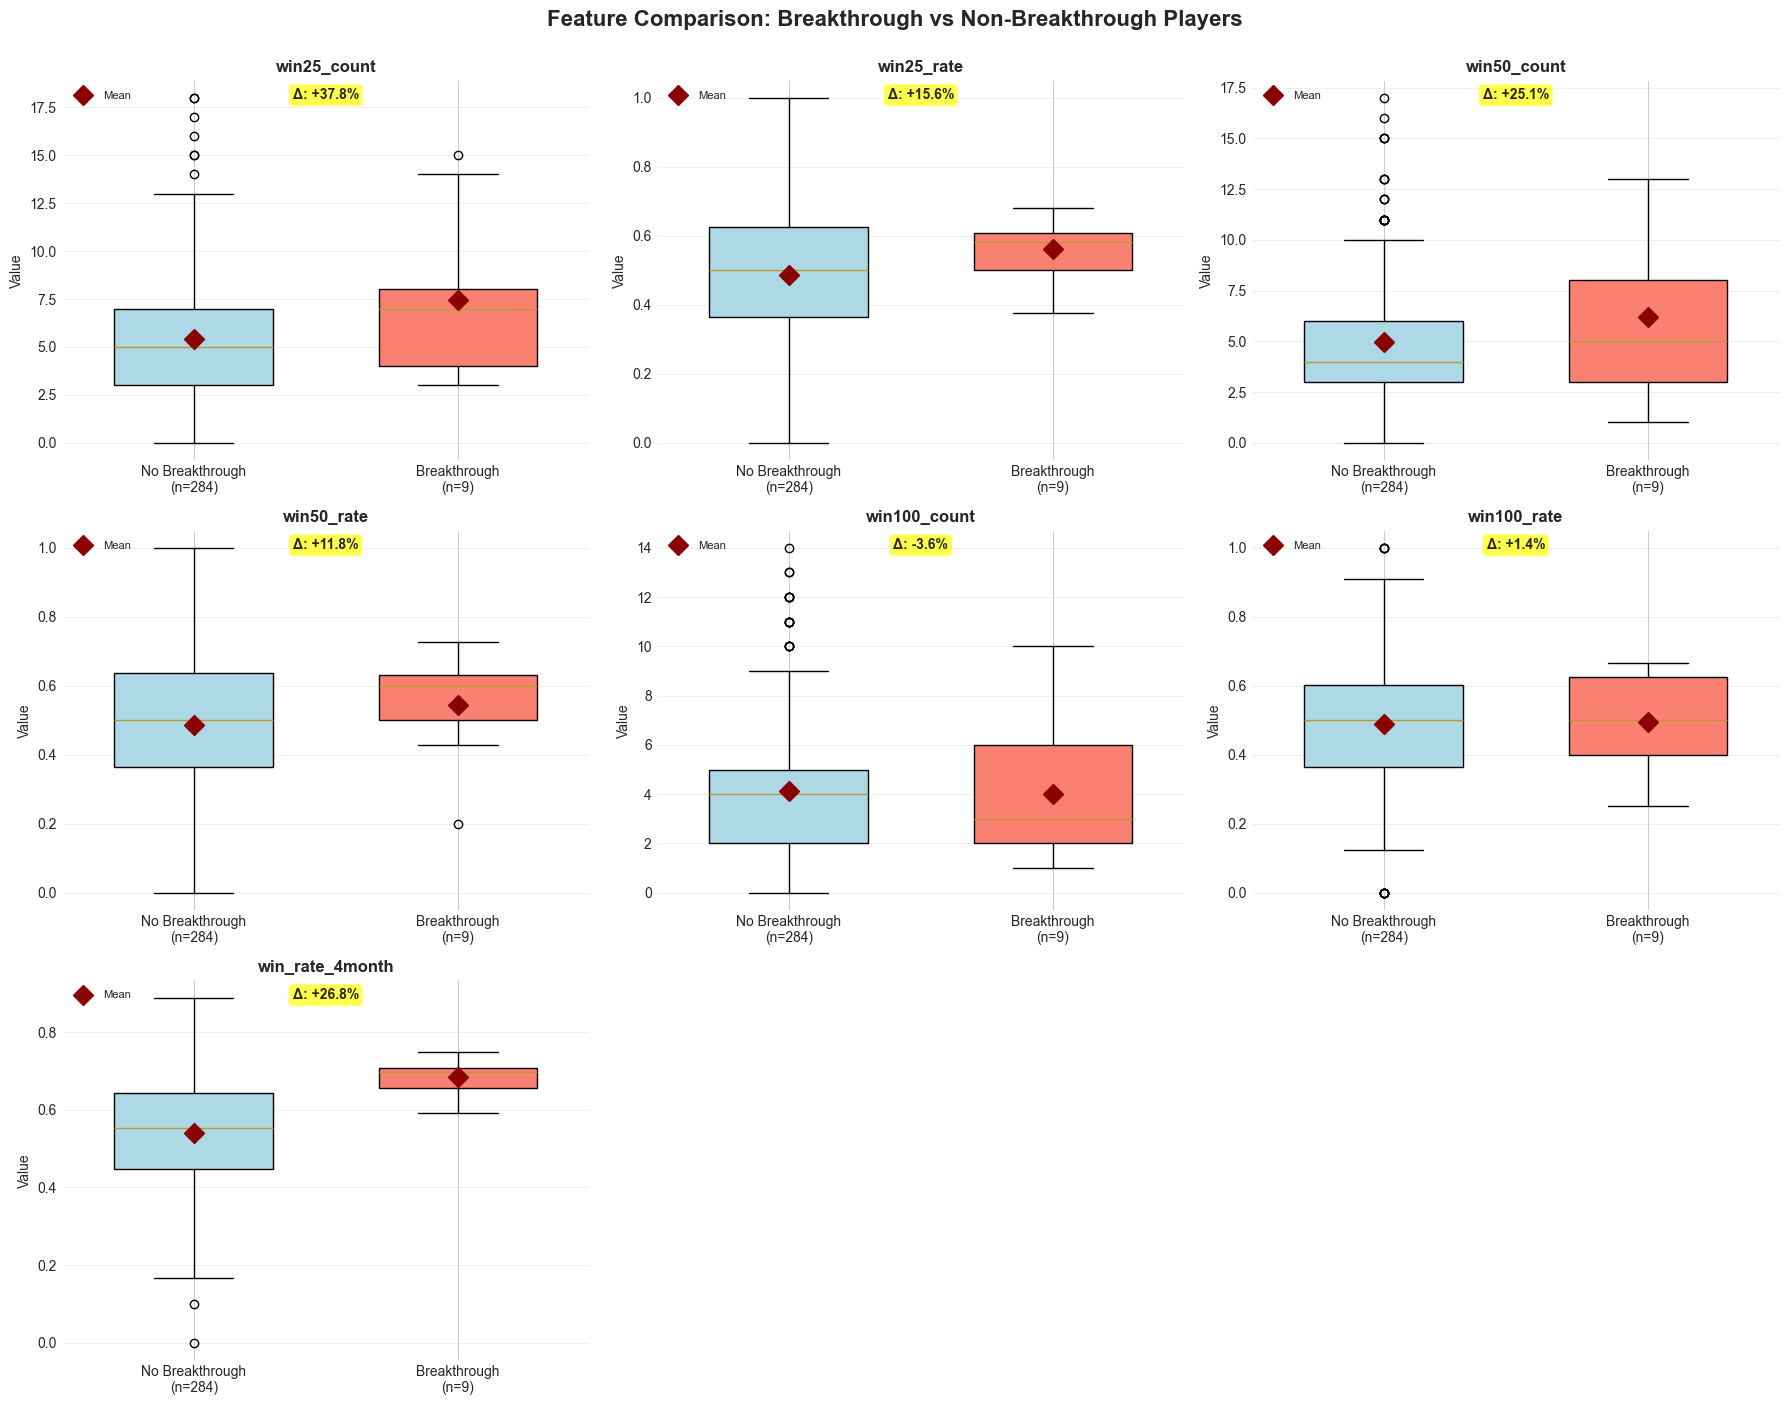


✅ Box plots created! Look for:
   • Separation between blue (no breakthrough) and red (breakthrough) boxes
   • Overlap: do the boxes overlap heavily or are they distinct?
   • Red diamonds (means): how far apart are they?
   • Yellow boxes show % difference - which features have biggest gaps?


In [ ]:
 # ============================================================================
# BREAKTHROUGH vs NON-BREAKTHROUGH COMPARISON - Box Plots
# ============================================================================

print("\n" + "="*80)
print("📊 BREAKTHROUGH vs NON-BREAKTHROUGH COMPARISON PLOTS")
print("="*80)

fig, axes = plt.subplots(3, 3, figsize=(18, 14))
axes = axes.flatten()

for i, feature in enumerate(features):
    # Create box plot
    data_to_plot = [
        non_breakthrough_players[feature],
        breakthrough_players[feature]
    ]
    
    bp = axes[i].boxplot(data_to_plot, 
                         tick_labels=['No Breakthrough\n(n=284)', 'Breakthrough\n(n=9)'],
                         patch_artist=True,
                         widths=0.6)
    
    # Color the boxes
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][1].set_facecolor('salmon')
    
    axes[i].set_title(f'{feature}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Value')
    axes[i].grid(axis='y', alpha=0.3)
    
    # Add means as red diamonds
    means = [
        non_breakthrough_players[feature].mean(),
        breakthrough_players[feature].mean()
    ]
    axes[i].plot([1, 2], means, 'D', color='darkred', markersize=10, 
                label='Mean', zorder=3)
    
    # Add percentage difference annotation
    pct_diff = (means[1] - means[0]) / means[0] * 100
    axes[i].text(0.5, 0.98, f'Δ: {pct_diff:+.1f}%', 
                transform=axes[i].transAxes,
                verticalalignment='top', horizontalalignment='center',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontsize=10, fontweight='bold')
    
    axes[i].legend(loc='upper left', fontsize=8)

# Remove extra subplots
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle('Feature Comparison: Breakthrough vs Non-Breakthrough Players', 
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print("\n✅ Box plots created! Look for:")
print("   • Separation between blue (no breakthrough) and red (breakthrough) boxes")
print("   • Overlap: do the boxes overlap heavily or are they distinct?")
print("   • Red diamonds (means): how far apart are they?")
print("   • Yellow boxes show % difference - which features have biggest gaps?")



🔥 CORRELATION HEATMAP - Feature Relationships


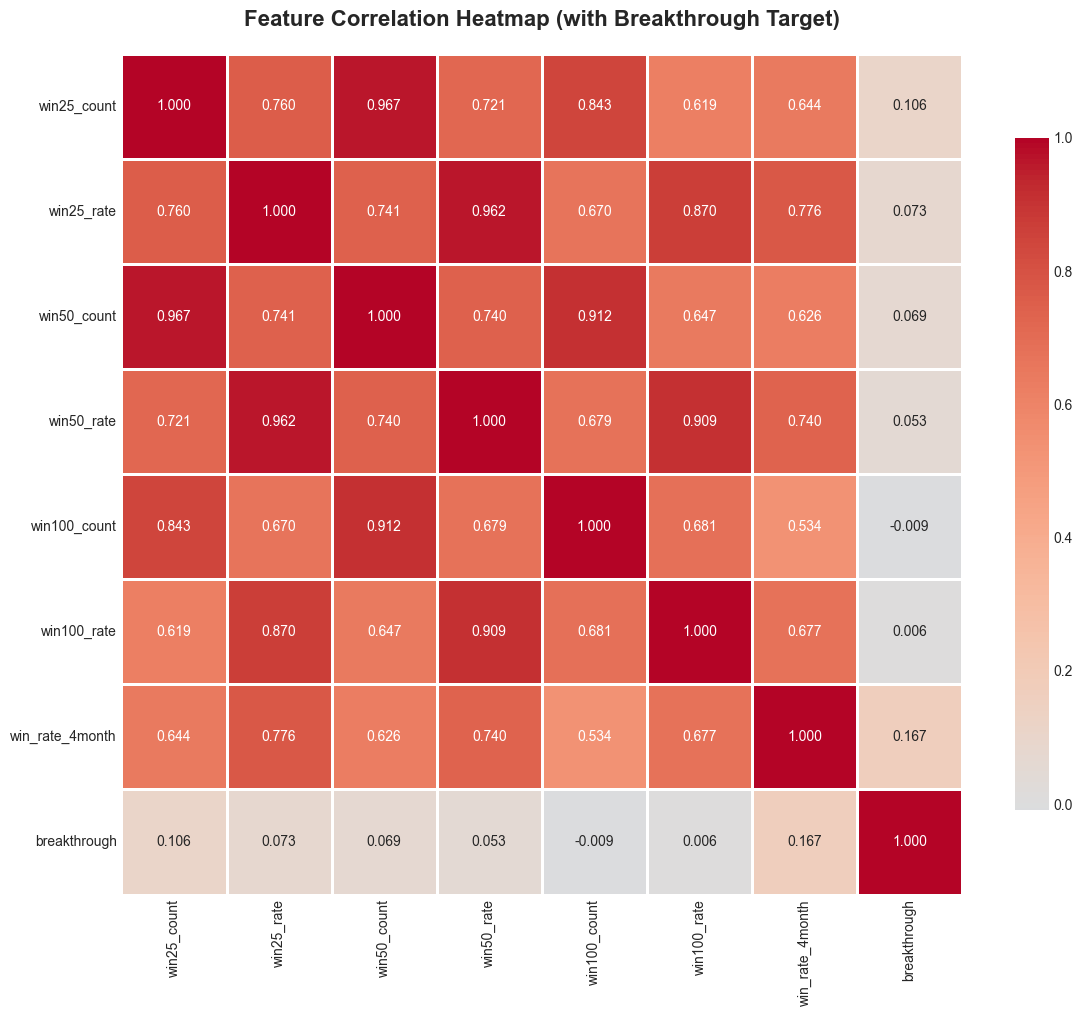


📊 CORRELATIONS WITH BREAKTHROUGH (sorted by strength):
------------------------------------------------------------
win_rate_4month     : +0.1675  🔥 Strong
win25_count         : +0.1062  📊 Moderate
win25_rate          : +0.0735  💀 Weak
win50_count         : +0.0695  💀 Weak
win50_rate          : +0.0529  💀 Weak
win100_rate         : +0.0060  💀 Weak
win100_count        : -0.0093  💀 Weak

📊 FEATURE MULTICOLLINEARITY (high correlations between features):
------------------------------------------------------------
⚠️  High correlation pairs (>0.85) - potential redundancy:
   win25_count <-> win50_count: 0.967
   win25_rate <-> win50_rate: 0.962
   win50_count <-> win100_count: 0.912
   win50_rate <-> win100_rate: 0.909
   win25_rate <-> win100_rate: 0.870


In [ ]:
# ============================================================================
# CORRELATION HEATMAP - See all feature relationships
# ============================================================================

print("\n" + "="*80)
print("🔥 CORRELATION HEATMAP - Feature Relationships")
print("="*80)

# Create correlation matrix for all features + target
features_plus_target = features + ['breakthrough']
correlation_matrix = df[features_plus_target].corr()

# Create the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, 
            annot=True,  # Show correlation values
            fmt='.3f',   # 3 decimal places
            cmap='coolwarm',  # Blue = negative, Red = positive
            center=0,    # White at 0
            square=True, 
            linewidths=1,
            cbar_kws={"shrink": 0.8})

plt.title('Feature Correlation Heatmap (with Breakthrough Target)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Analyze correlations with target specifically
print("\n📊 CORRELATIONS WITH BREAKTHROUGH (sorted by strength):")
print("-"*60)
target_correlations = correlation_matrix['breakthrough'].drop('breakthrough').sort_values(ascending=False)
for feature, corr in target_correlations.items():
    strength = "🔥 Strong" if abs(corr) > 0.15 else "📊 Moderate" if abs(corr) > 0.08 else "💀 Weak"
    print(f"{feature:20s}: {corr:+.4f}  {strength}")

print("\n📊 FEATURE MULTICOLLINEARITY (high correlations between features):")
print("-"*60)
# Find highly correlated feature pairs (excluding diagonal and target)
high_corr_pairs = []
for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_val = correlation_matrix.loc[features[i], features[j]]
        if abs(corr_val) > 0.85:  # High correlation threshold
            high_corr_pairs.append((features[i], features[j], corr_val))

if high_corr_pairs:
    print("⚠️  High correlation pairs (>0.85) - potential redundancy:")
    for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
        print(f"   {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("✅ No highly correlated feature pairs found")

In [ ]:
# ============================================================================
# INVESTIGATING RANKING IMPROVEMENTS - Is there more signal here?
# ============================================================================

print("="*80)
print("🔍 EXPLORING RANKING IMPROVEMENT AS ALTERNATIVE TARGET")
print("="*80)

# We need to see the actual ranking changes for all 293 players
# Unfortunately, we don't have that data loaded yet!

print("\n❓ KEY QUESTION: What happened to all 293 players?")
print("-"*80)
print("Current target breakdown:")
print(f"  Breakthrough (top 50): {breakthrough_counts[1]} players (3.1%)")
print(f"  Non-breakthrough: {breakthrough_counts[0]} players (96.9%)")
print("\nBut within 'non-breakthrough', we don't know:")
print("  • How many reached top 100?")
print("  • How many reached top 150?")  
print("  • How many improved at all?")
print("  • How many stayed the same or declined?")

print("\n💡 HYPOTHESIS: The 284 'non-breakthrough' players have varying outcomes")
print("   Some probably reached top 100-150 (impressive but not 'breakthrough')")
print("   Some probably stayed at their level (~200-500)")
print("   Some probably declined or retired")
print("\n   Your features might predict RANKING CHANGE better than binary breakthrough!")

🔍 EXPLORING RANKING IMPROVEMENT AS ALTERNATIVE TARGET

❓ KEY QUESTION: What happened to all 293 players?
--------------------------------------------------------------------------------
Current target breakdown:
  Breakthrough (top 50): 9 players (3.1%)
  Non-breakthrough: 284 players (96.9%)

But within 'non-breakthrough', we don't know:
  • How many reached top 100?
  • How many reached top 150?
  • How many improved at all?
  • How many stayed the same or declined?

💡 HYPOTHESIS: The 284 'non-breakthrough' players have varying outcomes
   Some probably reached top 100-150 (impressive but not 'breakthrough')
   Some probably stayed at their level (~200-500)
   Some probably declined or retired

   Your features might predict RANKING CHANGE better than binary breakthrough!


???
🔍 INVESTIGATING RANKING OUTCOMES (2022-2023)

We have 293 players to investigate

📊 Step 1: Getting July 2021 baseline rankings...
--------------------------------------------------------------------------------
Found baseline rankings for 293 players

Baseline ranking stats:
count     293.000000
mean      551.709898
std       260.382453
min       109.000000
25%       336.000000
50%       547.000000
75%       709.000000
max      2085.000000
Name: baseline_rank, dtype: float64

📊 Step 2: Getting best rankings achieved Jan 2022 - July 2023...
--------------------------------------------------------------------------------
Found best rankings for 293 players

Best ranking stats:
count     293.000000
mean      369.546075
std       224.517402
min         6.000000
25%       188.000000
50%       336.000000
75%       524.000000
max      1191.000000
Name: best_rank, dtype: float64

📊 Step 3: Calculating ranking improvements...
----------------------------------------------------------------

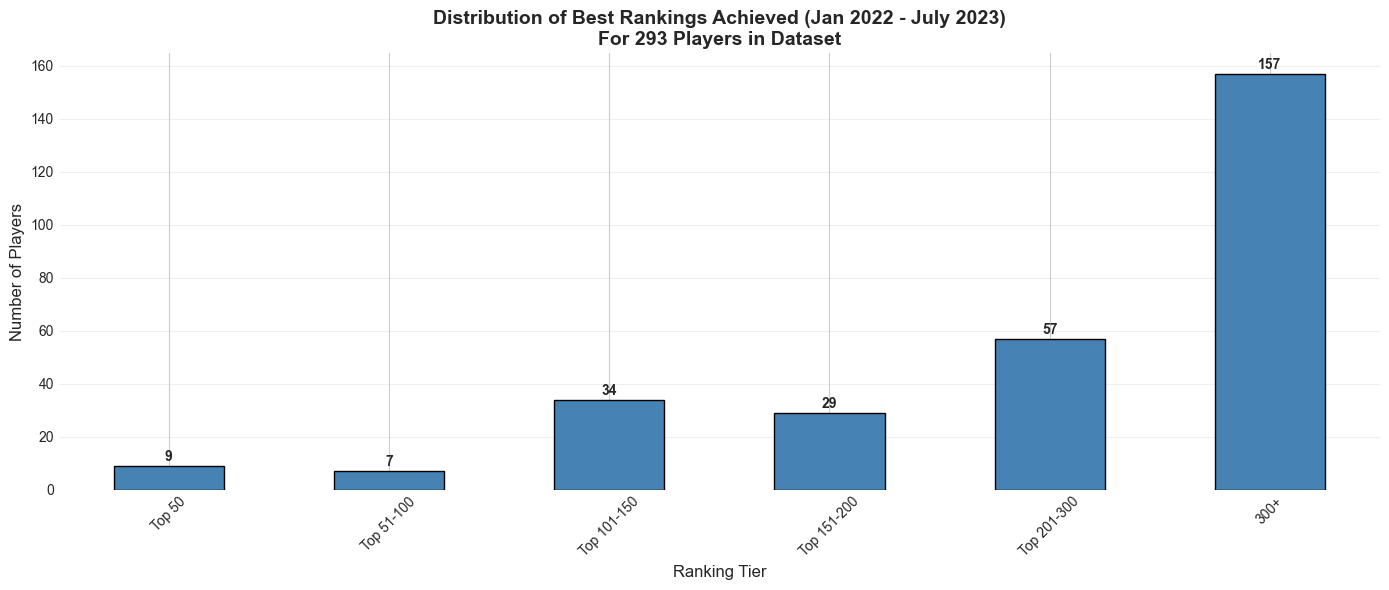


📊 Percentage Breakdown:
Top 50              :   9 players (  3.1%)
Top 51-100          :   7 players (  2.4%)
Top 101-150         :  34 players ( 11.6%)
Top 151-200         :  29 players (  9.9%)
Top 201-300         :  57 players ( 19.5%)
300+                : 157 players ( 53.6%)

⚖️  CURRENT vs GRADIENT:
--------------------------------------------------------------------------------
Current 'breakthrough' definition (top 50): 9 players (3.1%)
Reached top 100: 16 players
Reached top 150: 50 players
Improved 100+ spots: 173 players

✅ Investigation complete!


In [ ]:
print("???")
# ============================================================================
# INVESTIGATION: Ranking Outcomes for 293 Players (FIXED)
# ============================================================================

import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Connect to your database
conn = sqlite3.connect('tennis_breakthrough.db')  # Update with your actual path

print("="*80)
print("🔍 INVESTIGATING RANKING OUTCOMES (2022-2023)")
print("="*80)

# First, let's get the list of player_ids from our CSV dataset
player_ids = df['player_id'].tolist()
player_ids_str = ','.join(map(str, player_ids))

print(f"\nWe have {len(player_ids)} players to investigate")

# Step 1: Get baseline rankings (July 2021) for our 293 players
print("\n📊 Step 1: Getting July 2021 baseline rankings...")
print("-"*80)

baseline_query = f"""
SELECT 
    player_id,
    MIN(rank) as baseline_rank,
    ranking_date as baseline_date
FROM rankings
WHERE ranking_date BETWEEN 20210701 AND 20210731
  AND player_id IN ({player_ids_str})
GROUP BY player_id
"""

baseline_df = pd.read_sql_query(baseline_query, conn)
print(f"Found baseline rankings for {len(baseline_df)} players")
print(f"\nBaseline ranking stats:")
print(baseline_df['baseline_rank'].describe())

# Step 2: Get best ranking achieved (Jan 2022 - July 2023)
print("\n📊 Step 2: Getting best rankings achieved Jan 2022 - July 2023...")
print("-"*80)

best_rank_query = f"""
SELECT 
    player_id,
    MIN(rank) as best_rank,
    ranking_date as date_of_best_rank
FROM rankings
WHERE ranking_date BETWEEN 20220101 AND 20230731
  AND player_id IN ({player_ids_str})
GROUP BY player_id
"""

best_rank_df = pd.read_sql_query(best_rank_query, conn)
print(f"Found best rankings for {len(best_rank_df)} players")
print(f"\nBest ranking stats:")
print(best_rank_df['best_rank'].describe())

# Step 3: Merge and calculate ranking improvement
print("\n📊 Step 3: Calculating ranking improvements...")
print("-"*80)

ranking_outcomes = baseline_df.merge(best_rank_df, on='player_id', how='left')

# Calculate improvement (positive = better, negative = worse)
ranking_outcomes['ranking_improvement'] = ranking_outcomes['baseline_rank'] - ranking_outcomes['best_rank']

# Handle players with no future ranking data (retired/inactive)
missing_future = ranking_outcomes['best_rank'].isna().sum()
if missing_future > 0:
    print(f"⚠️  {missing_future} players have no ranking data in 2022-2023 (retired/inactive)")
    ranking_outcomes['best_rank'].fillna(ranking_outcomes['baseline_rank'], inplace=True)
    ranking_outcomes['ranking_improvement'].fillna(0, inplace=True)

print(f"\nRanking improvement stats:")
print(ranking_outcomes['ranking_improvement'].describe())

# Show top improvers
print(f"\n🏆 TOP 10 IMPROVERS:")
top_improvers = ranking_outcomes.nlargest(10, 'ranking_improvement')[['player_id', 'baseline_rank', 'best_rank', 'ranking_improvement']]
print(top_improvers.to_string(index=False))

# Show decliners
print(f"\n📉 TOP 10 DECLINERS:")
decliners = ranking_outcomes.nsmallest(10, 'ranking_improvement')[['player_id', 'baseline_rank', 'best_rank', 'ranking_improvement']]
print(decliners.to_string(index=False))

# Merge with original dataset
df_with_outcomes = df.merge(ranking_outcomes[['player_id', 'baseline_rank', 'best_rank', 'ranking_improvement']], 
                             on='player_id', how='left')

# Step 4: Create ranking tiers
print("\n📊 Step 4: Categorizing outcomes into tiers...")
print("-"*80)

df_with_outcomes['tier'] = pd.cut(df_with_outcomes['best_rank'], 
                                   bins=[0, 50, 100, 150, 200, 300, 2000],
                                   labels=['Top 50', 'Top 51-100', 'Top 101-150', 
                                          'Top 151-200', 'Top 201-300', '300+'])

tier_distribution = df_with_outcomes['tier'].value_counts().sort_index()
print("\n🎯 OUTCOME DISTRIBUTION:")
print(tier_distribution)

# Visualize tier distribution
plt.figure(figsize=(14, 6))
tier_distribution.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Distribution of Best Rankings Achieved (Jan 2022 - July 2023)\nFor 293 Players in Dataset', 
          fontsize=14, fontweight='bold')
plt.xlabel('Ranking Tier', fontsize=12)
plt.ylabel('Number of Players', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(tier_distribution):
    plt.text(i, v + 2, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

# Show percentage breakdown
print("\n📊 Percentage Breakdown:")
for tier, count in tier_distribution.items():
    pct = count / len(df_with_outcomes) * 100
    print(f"{tier:20s}: {count:3d} players ({pct:5.1f}%)")

# Compare to current breakthrough definition
print("\n⚖️  CURRENT vs GRADIENT:")
print("-"*80)
print(f"Current 'breakthrough' definition (top 50): {(df_with_outcomes['breakthrough']==1).sum()} players (3.1%)")
print(f"Reached top 100: {(df_with_outcomes['best_rank'] <= 100).sum()} players")
print(f"Reached top 150: {(df_with_outcomes['best_rank'] <= 150).sum()} players")
print(f"Improved 100+ spots: {(df_with_outcomes['ranking_improvement'] >= 100).sum()} players")

conn.close()

print("\n✅ Investigation complete!")